#### Editing log:
##### Orignal from 09/18/2022
##### Edited on 02/15/2023: adding mutation features
##### Edited on 02/21/2023: finish analysis
##### Edited on 03/01/2023: updated miRNA data
##### Edited on 03/09/2023: clean the script
##### Edited on 06/20/2023: revised the script

In [1]:
# Load libraries
import pandas as pd
from sklearn import linear_model 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score, balanced_accuracy_score
#from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score
import pandas as pd
import numpy as np
from scipy.stats import stats
import os
import matplotlib.pyplot as plt
from random import choices
import xgboost as xgb
import xgboost as XGBClassifier

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score


In [66]:
# Define functions

def Filter_low_Expr(arr):
    
    #input: arr: a list of expression values for a gene across all samples
    #output: True or False that indicates whether this gene show expression greater than 0 in more than 50% of the samples
    
    total_len = len(arr)
    count = 0
    for i in arr:
        if i > 0:
            count = count + 1
    if count > 0.5*total_len: #If 
        return(True)
    else:
        return(False)
    
def formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map):
    array_list = []
    new_id_list = []
    for gene1 in selected_genes_id:

        for gene2 in sele_house_keeping_id:
            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    for gene1 in selected_genes_id:
        cur_sele = KG_reg.loc[KG_reg['Target_gene'] == gene1]
        cur_regulators = list(cur_sele.loc[cur_sele['Coef'] < 0]['Regulator'])
        if gene1+"_intercept_" in cur_regulators:
            cur_regulators.remove(gene1+"_intercept_")
        #cur_regulators.remove(gene1+"_RSS")
        cur_regulators_ids = []
        for gene2 in cur_regulators:
            gene2 = dic_gene_map[gene2]
            #cur_regulators_ids.append(dic_gene_map[i])

            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    new_feature_df = pd.DataFrame(array_list)
    new_feature_df.columns = input_data.columns
    new_feature_df.index = new_id_list
    new_feature_df_t = new_feature_df.transpose()
    return(new_feature_df_t)


def train_test_split_gq(df_sele, binary_cutoff, test_size): #stratified sampling
    from sklearn.model_selection import train_test_split
    df_neg = df_sele.loc[df_sele['ic50'] > binary_cutoff]
    df_train_1, df_test_1 = train_test_split(df_neg, test_size = test_size)
    df_pos = df_sele.loc[df_sele['ic50'] <= binary_cutoff]
    df_train_2, df_test_2 = train_test_split(df_pos, test_size = test_size)
    
    df_train = pd.concat([df_train_1,df_train_2])
    df_test = pd.concat([df_test_1, df_test_2])
    
    return(df_train, df_test)


def model_run_with_Independent_testSet(train_data,test_data, train_labels, test_labels, independent_labels, independent_features,random_): #modified at 11:46 AM Feb 15
    result_summary = {}
    
    if len(independent_labels) <= 1:
        return(result_summary)
    
    xgb_model = xgb.XGBClassifier(n_jobs=4)
    clf = GridSearchCV(xgb_model, {#'max_depth': [2],
                                   'max_depth': [2,3,4],
                                   'n_estimators': [100], 
                                   'learning_rate': [0.05, 0.1],
                                  
                                   #'gamma':[1],
                                   #'eta':[0.2,0.3,0.4],
                                  # 'min_child_weight':[1,2],
                                  # 'lambda':[1,2],
                                  # 'subsample':[0.8]
                                  }, verbose=1,cv=5, n_jobs=4) #5-fold cross validation

    clf.fit(train_data, train_labels.values)
    #print(clf.best_score_) #Train data
    para = (clf.best_params_)
    #print(clf.best_params_)

    xgb_model = xgb.XGBClassifier(n_jobs=1, learning_rate = para['learning_rate'], 
                                  max_depth=para['max_depth'], 
                                  n_estimators=para['n_estimators'])
    
    xgb_model.fit(train_data,train_labels.values)

    #prediction_train = clf.predict(train_data)

    #predictions = xgb_model.predict(test_data)

    predictions_training = clf.predict(train_data)
    accuracy_traing = accuracy_score(train_labels, predictions_training)
    #cm_traing = confusion_matrix(  list(train_labels), predictions_training)
    #sensitivity_traing = cm_traing[1,1]/(cm_traing[1,0] + cm_traing[1,1])
    #specificity_traing = cm_traing[0,0]/(cm_traing[0,0] + cm_traing[0,1])
    #precision_traing = cm_traing[1,1]/(cm_traing[0,1] + cm_traing[1,1])
    recall_traing = recall_score(train_labels, predictions_training)
    blanced_acc_traing = balanced_accuracy_score(train_labels, predictions_training) #(sensitivity_traing + specificity_traing) /2
    f1_traing = f1_score(list(train_labels), predictions_training)

    
    predictions = clf.predict(test_data)
    
    predictions_independent = clf.predict(independent_features)
    

    #print(pd.DataFrame({"Meausred": list(test_labels), "Predict": predictions}))

    # Evaluate the accuracy of the XGBoost model in the validation set (beatAML wave 1/2)
    accuracy = accuracy_score(test_labels, predictions)
    #cm = confusion_matrix(  list(test_labels), predictions)
    #print("cm:")
    #print(cm)
    #tn = cm[0,0] #labled as negative and predicted as negative 
    #fp = cm[0,1] #labeld as negative and predicted as positive
    #fn = cm[1,0] #labeld as positive, and predicted as negative
    #tp = cm[1,1] #labeld as positive, and predicted as positive
    
    #sensitivity = cm[1,1]/(cm[1,0] + cm[1,1]) # TP/(FN + TP)
    #specificity = tn/(tn+fp)
    
    #precision = cm[1,1]/(cm[0,1] + cm[1,1])
    #recall = recall_score(test_labels, predictions)
    blanced_acc = balanced_accuracy_score(test_labels, predictions) #(sensitivity + specificity) /2 
    f1 = f1_score(test_labels, predictions)
    
    # Evaluate the accuracy of the XGBoost model in the testing set (beatAML wave 3/4)
    #accuracy_independent = accuracy_score(independent_labels, predictions_independent)
    f1_independent = f1_score(independent_labels, predictions_independent)
    #cm_independent = confusion_matrix(  list(independent_labels), predictions_independent)
    #print("cm_independent:")
    #print(cm_independent)
    #print(cm_independent)
    #tn_independent = cm_independent[0,0] #labled as negative and predicted as negative 
    #fp_independent = cm_independent[0,1] #labeld as negative and predicted as positive
    #fn_independent = cm_independent[1,0] #labeld as positive, and predicted as negative
    #tp_independent = cm_independent[1,1] #labeld as positive, and predicted as positive
    
    #sensitivity_independent = cm_independent[1,1]/(cm_independent[1,0] + cm_independent[1,1]) # TP/(FN + TP)
    
    #specificity_independent = tn_independent/(tn_independent+fp_independent)
    
    #precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
    #recall_independent = recall_score(independent_labels, predictions_independent)
    blanced_acc_independent = balanced_accuracy_score(independent_labels, predictions_independent) #(sensitivity_independent + specificity_independent) /2 
    recall_independent = recall_score(independent_labels, predictions_independent)
    # F1 = 2 x [(Precision x Recall) / (Precision + Recall)]

    #print("F1_score: " + str(f1))
    #print("# F1: 2 x [(Precision x Recall) / (Precision + Recall)]")

    result_feature = pd.DataFrame({"Feature":list(test_data.columns), "IMP":xgb_model.feature_importances_})
    result_feature= result_feature.loc[result_feature['IMP']>0].sort_values(by = ['IMP'], ascending = False)

    #features = ((list(result_feature.loc[result_feature['IMP']>0.05].sort_values(by = ["IMP"], ascending = False)['Feature'])))

    
    result_summary['random_state'] = random_
    result_summary['best_params'] = clf.best_params_

    #result_summary['Acuracy_training'] = accuracy_traing
    #result_summary['Precision_training'] = precision_traing
    #result_summary['sensitivity_training'] = sensitivity_traing
    result_summary['F1_score_training'] = f1_traing
    #result_summary['specificity_training'] = specificity_traing
    result_summary['balanced_acc_training'] = blanced_acc_traing
    #result_summary['recall_training'] = recall_traing
    
    result_summary['Accuracy'] = accuracy #1
    #result_summary['Precision'] = precision #2
    #result_summary['sensitivity'] = sensitivity #3
    result_summary['F1_score'] = f1 #4
    #result_summary['specificity'] = specificity #5
    result_summary['balanced_acc'] = blanced_acc #6
    #result_summary['recall'] = recall #7
    
    
    #result_summary['precision_independent'] = precision_independent #1
    #result_summary['sensitivity_independent'] =sensitivity_independent #2
    #result_summary['specificity_independent'] = specificity_independent #3
    result_summary['blanced_acc_independent'] = blanced_acc_independent #4
    #result_summary['ACC_independent'] = accuracy_independent #5
    result_summary['F1_score_independent'] = f1_independent #6
    #result_summary['recall_independent'] = recall_independent #7
    
    result_summary['features'] = result_feature
    return(result_summary)

def select_duplicated_col(my_list):
    duplicates = []
    for item in my_list:
        if my_list.count(item) > 1:
            if item not in duplicates:
                duplicates.append(item)
    return(duplicates)

def features(Drug, KG_expr_resp,KG_reg,dic_gene_map, input_data, input_data_test, BeatAML_mut_matrix_sele_w3_4, mut_w1_2, sele_house_keeping ):
    res1 = KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]
    res1 = res1.sort_values(by = ['coef'])
    predictors = list(res1['Gene'])
    predictors.remove(Drug+"_RSS")
    predictors.remove(Drug+"_intercept")
    
    # Selection of the second neighbors
    #res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors[0:5] +  predictors[len(predictors)-5:len(predictors)])]
    res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors)]
    res2 = res2.loc[res2['Coef'] <0]

    selected_genes = list(KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]['Symbol'])
    selected_genes.remove(Drug+"_RSS")
    selected_genes.remove(Drug+"_intercept")
        

    print(len(selected_genes))

    # Formating house keeping gene ids
    sele_house_keeping_id = []
    selected_genes_id = []

    for g in selected_genes:
        selected_genes_id.append(dic_gene_map[g])

    for g in sele_house_keeping:
        if g in dic_gene_map:
            sele_house_keeping_id.append(dic_gene_map[g])

    # Formatting features
    new_feature_df_t = formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map)
    new_feature_df_test = formating_relative_expression(input_data_test,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map)

    new_feature_df_test_comb = pd.concat([BeatAML_mut_matrix_sele_w3_4, new_feature_df_test], axis = 1)
    new_feature_df_t_comb = pd.concat([mut_w1_2,new_feature_df_t],axis = 1)

    new_feature_df_test = new_feature_df_test_comb.dropna()
    new_feature_df_t = new_feature_df_t_comb.dropna()

    return(new_feature_df_t,new_feature_df_test)


In [4]:
# Load data
# Gene expression from BeatAML wave 1 and 2
Drug_data = pd.read_csv("../../../Data_resource/Drug_Response.csv",index_col = "Unnamed: 0") 


GE = pd.read_csv("../../../Data_resource/RPKM.csv",index_col = "Unnamed: 0")
data_all  = pd.read_csv("./beatAML_wave1_2_feature_ic50_highExpr.csv", index_col= "Unnamed: 0")
mut_w1_2 = data_all.iloc[:,0:22].dropna()

#Load features from features that predict drug response, regulatory graph and house keeping genes
#sele_house_keeping =  ["GPS2", "RPS10","ZNF91","FNTA","PSMC1","GPS1","MLH1","ARAF","SF3B2","PSMD2","SRP14","GNB1","HNRNPK","ARF1","RPS11"]
sele_house_keeping = ['RPS10','FNTA','COX6A1','BECN1', 'SF3B2','PSMB2','AUP1','SRP14','HNRNPK', 'CCNI', 'RHOA', 'PABPC1','RPS11','TPT1','FTL']

#KG_expr_resp = pd.read_csv("../KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv")
#KG_reg = pd.read_csv("../KG_regulatory_graph.csv")

KG_expr_resp = pd.read_csv("../../../../Manuscript/Supplemental_Tables/Supplemental_2_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv")
KG_reg = pd.read_csv("KG_regulatory_graph_Mar1_2023.csv")


# Load testing data from BeatAML wave 1-4
BeatAML_wave_3_expr = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/rnaseq/beataml_waves1to4_allnorm.txt", sep = "\t") 
BeatAML_wave_3_drugResponse = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/inhibitor/beataml_probit_curve_fits_v4_distr_nonproprietary.txt", sep = "\t")
BeatAML_mut_matrix_sele_w3_4 = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/BeatAML_mut_matrix_sele_w3_4.csv", index_col = "Unnamed: 0")

In [48]:
list(Drugs['Drug'])

['Elesclomol',
 'Trametinib (GSK1120212)',
 'Ponatinib (AP24534)',
 'INK-128',
 'Dasatinib',
 'Panobinostat',
 'JNJ-28312141',
 'Rapamycin',
 'Foretinib (XL880)',
 'Quizartinib (AC220)',
 'Venetoclax',
 'Sunitinib',
 'Dovitinib (CHIR-258)',
 'Doramapimod (BIRB 796)',
 'PI-103',
 'SNS-032 (BMS-387032)',
 'Selumetinib (AZD6244)',
 'Flavopiridol',
 'BEZ235',
 'PP242',
 'Gilteritinib (ASP-2215)',
 'KI20227',
 'JAK Inhibitor I',
 'Tivozanib (AV-951)',
 'Bortezomib (Velcade)',
 'Lestaurtinib (CEP-701)',
 'Midostaurin',
 'Idelalisib',
 'Cabozantinib',
 'MK-2206',
 'Sorafenib',
 'Selinexor',
 '17-AAG (Tanespimycin)',
 'Crenolanib',
 'GDC-0941',
 'KW-2449',
 'RAF265 (CHIR-265)',
 'MGCD-265',
 'JQ1',
 'Pelitinib (EKB-569)',
 'CHIR-99021',
 'Masitinib (AB-1010)',
 'NF-kB Activation Inhibitor',
 'CI-1040 (PD184352)',
 'GSK690693',
 'Neratinib (HKI-272)',
 'NVP-TAE684',
 'CYT387',
 'S31-201',
 'Ibrutinib (PCI-32765)',
 'VX-745',
 'A-674563',
 'ABT-737',
 'Axitinib (AG-013736)',
 'Vandetanib (ZD6474

In [153]:
'''
# check the distribution of drug sensitivity between the W1/2 or W3/4
Drug = "Venetoclax"
#Drug = "Cabozantinib"
#Drug = "JQ1"

arr = Drug_data.loc[Drug_data['inhibitor'] == Drug]['auc'].values
arr1 = BeatAML_wave_3_drugResponse.loc[BeatAML_wave_3_drugResponse['inhibitor'] == Drug]['auc'].values
import numpy as np
bins = np.linspace(0, 300, 10)

plt.hist(arr, bins, alpha=0.5, label='W1/2')
plt.hist(arr1, bins, alpha=0.5, label='W3/4')
plt.legend(loc='upper right')
plt.show()
'''

'\n\n\n# check the distribution of drug sensitivity between the W1/2 or W3/4\nDrug = "Venetoclax"\n#Drug = "Cabozantinib"\n#Drug = "JQ1"\n\narr = Drug_data.loc[Drug_data[\'inhibitor\'] == Drug][\'auc\'].values\narr1 = BeatAML_wave_3_drugResponse.loc[BeatAML_wave_3_drugResponse[\'inhibitor\'] == Drug][\'auc\'].values\nimport numpy as np\nbins = np.linspace(0, 300, 10)\n\nplt.hist(arr, bins, alpha=0.5, label=\'W1/2\')\nplt.hist(arr1, bins, alpha=0.5, label=\'W3/4\')\nplt.legend(loc=\'upper right\')\nplt.show()\n'

In [11]:
#plt.hist(BeatAML_wave_3_drugResponse.loc[BeatAML_wave_3_drugResponse['inhibitor'] == "JQ1"]['auc'])

In [154]:
'''

print("Number of drugs in BeatAML wave 1/2:" + str(len(set(Drug_data['inhibitor']))))
print("Number of samples with drug screening data in BeatAML wave 1/2:" + str(len(set(Drug_data['lab_id']))))
#print(data_all.shape)
print(mut_w1_2.shape)

'''

'\n\nprint("Number of drugs in BeatAML wave 1/2:" + str(len(set(Drug_data[\'inhibitor\']))))\nprint("Number of samples with drug screening data in BeatAML wave 1/2:" + str(len(set(Drug_data[\'lab_id\']))))\n#print(data_all.shape)\nprint(mut_w1_2.shape)\n\n'

In [5]:
#Formating gene expression data for training data
GE.index = GE['Gene']
gene_list_w12 = (list(GE.index))
sample_list_w12 = list(set(GE.columns) - set(['Gene','Symbol']))
input_data = GE.loc[list(gene_list_w12), sample_list_w12]


#Formating gene expression data for testing data
BeatAML_wave_3_expr.index = BeatAML_wave_3_expr['stable_id']
gene_list = (list(BeatAML_wave_3_expr.index))
sample_list = list(set(BeatAML_wave_3_expr.columns) - set(['stable_id','display_label','description','biotype']) - set(sample_list_w12))
input_data_test = BeatAML_wave_3_expr.loc[list(gene_list), sample_list]

# Define gene_map
gene_map = GE.loc[:,['Gene','Symbol']]
dic_gene_map = {}
for i in range(0,gene_map.shape[0]):
    dic_gene_map[gene_map.iloc[i,0]] = gene_map.iloc[i,1]
    dic_gene_map[gene_map.iloc[i,1]] = gene_map.iloc[i,0]


In [6]:
Drugs = pd.read_csv("/Users/guangrong/Documents/GitHub_project/AML_BeatAML/Manuscript/Supplemental_Tables/Supplemental_1_Number_of_effective_cases.csv")

In [10]:
Drugs = list(Drugs['Drug'])
print(Drugs)
print(len(Drugs))



['Elesclomol', 'Trametinib (GSK1120212)', 'Ponatinib (AP24534)', 'INK-128', 'Dasatinib', 'Panobinostat', 'JNJ-28312141', 'Rapamycin', 'Foretinib (XL880)', 'Quizartinib (AC220)', 'Venetoclax', 'Sunitinib', 'Dovitinib (CHIR-258)', 'Doramapimod (BIRB 796)', 'PI-103', 'SNS-032 (BMS-387032)', 'Selumetinib (AZD6244)', 'Flavopiridol', 'BEZ235', 'PP242', 'Gilteritinib (ASP-2215)', 'KI20227', 'JAK Inhibitor I', 'Tivozanib (AV-951)', 'Bortezomib (Velcade)', 'Lestaurtinib (CEP-701)', 'Midostaurin', 'Idelalisib', 'Cabozantinib', 'MK-2206', 'Sorafenib', 'Selinexor', '17-AAG (Tanespimycin)', 'Crenolanib', 'GDC-0941', 'KW-2449', 'RAF265 (CHIR-265)', 'MGCD-265', 'JQ1', 'Pelitinib (EKB-569)', 'CHIR-99021', 'Masitinib (AB-1010)', 'NF-kB Activation Inhibitor', 'CI-1040 (PD184352)', 'GSK690693', 'Neratinib (HKI-272)', 'NVP-TAE684', 'CYT387', 'S31-201', 'Ibrutinib (PCI-32765)', 'VX-745', 'A-674563', 'ABT-737', 'Axitinib (AG-013736)', 'Vandetanib (ZD6474)', 'Bosutinib (SKI-606)', 'Vargetef', 'Pazopanib (GW7

In [155]:
'''

import scipy
import numpy as np
#plt.figure(figsize = (10,10),dpi = 300)
figure, axis = plt.subplots(10, 10)
figure.set_size_inches(40, 40)

plt.legend(loc='upper right')
bins = np.linspace(-5, 5, 30)
plt.legend(loc='upper right')

i = 0
j = 0
for Drug in Drugs:
    print(Drug)
    arr = np.log(Drug_data.loc[Drug_data['inhibitor'] == Drug]['ic50'].values)
    arr1 = np.log(BeatAML_wave_3_drugResponse.loc[BeatAML_wave_3_drugResponse['inhibitor'] == Drug]['ic50'].values)
    
    print([i,j])
    axis[i, j].hist(arr, bins, alpha=0.5, label='W1/2')
    axis[i, j].hist(arr1, bins, alpha=0.5, label='W3/4')
    
    
    #axis[i, j].set_ylabel("No. of samples")
    #axis[i, j].set_xlabel("log(IC50)")
    axis[i, j].set_title(Drug)
    
    i = i + 1
    if i > 9:
        j = j + 1
        i = 0
    #plt.show()
plt.savefig("drug_IC50_distribution.jpg", edgecolor='black', dpi=400, facecolor='white', transparent=False)
print(np.median(arr))
print(np.median(arr1))
scipy.stats.ranksums(arr, arr1)

'''

'\n\nimport scipy\nimport numpy as np\n#plt.figure(figsize = (10,10),dpi = 300)\nfigure, axis = plt.subplots(10, 10)\nfigure.set_size_inches(40, 40)\n\nplt.legend(loc=\'upper right\')\nbins = np.linspace(-5, 5, 30)\nplt.legend(loc=\'upper right\')\n\ni = 0\nj = 0\nfor Drug in Drugs:\n    print(Drug)\n    arr = np.log(Drug_data.loc[Drug_data[\'inhibitor\'] == Drug][\'ic50\'].values)\n    arr1 = np.log(BeatAML_wave_3_drugResponse.loc[BeatAML_wave_3_drugResponse[\'inhibitor\'] == Drug][\'ic50\'].values)\n    \n    print([i,j])\n    axis[i, j].hist(arr, bins, alpha=0.5, label=\'W1/2\')\n    axis[i, j].hist(arr1, bins, alpha=0.5, label=\'W3/4\')\n    \n    \n    #axis[i, j].set_ylabel("No. of samples")\n    #axis[i, j].set_xlabel("log(IC50)")\n    axis[i, j].set_title(Drug)\n    \n    i = i + 1\n    if i > 9:\n        j = j + 1\n        i = 0\n    #plt.show()\nplt.savefig("drug_IC50_distribution.jpg", edgecolor=\'black\', dpi=400, facecolor=\'white\', transparent=False)\nprint(np.median(arr

0                  Elesclomol
1     Trametinib (GSK1120212)
2         Ponatinib (AP24534)
3                     INK-128
4                   Dasatinib
               ...           
92                 Lovastatin
93       Afatinib (BIBW-2992)
94                   TG101348
95                 Lenvatinib
96                 NVP-ADW742
Name: Drug, Length: 97, dtype: object

In [82]:
#Drug = "Venetoclax"
result_with_threshod = {}
for Drug in list(Drugs['Drug']):
#for Drug in ["ABT-737"]:
    print(Drug)
    new_feature_df_t,new_feature_df_test = features(Drug, KG_expr_resp,KG_reg,dic_gene_map, input_data, input_data_test, BeatAML_mut_matrix_sele_w3_4, mut_w1_2, sele_house_keeping )
    result_with_threshod[Drug] = {}
    # Formatting trainning data
    Drug_sele_df = Drug_data.loc[Drug_data['inhibitor'] == Drug]
    Drug_sele_df.index = Drug_sele_df['lab_id']
    Drug_sele_df =Drug_sele_df.loc[:,['ic50']]

    df_sele = pd.concat([new_feature_df_t, Drug_sele_df],axis = 1)
    df_sele = df_sele.dropna()
    df_sele.head(3)
    df_sele.shape

    # Formatting testing data using beatAML wave 3/4
    Drug_sele_df_wave3 = BeatAML_wave_3_drugResponse.loc[BeatAML_wave_3_drugResponse['inhibitor'] == Drug]
    Drug_sele_df_wave3.index = Drug_sele_df_wave3['lab_id']
    Drug_sele_df_wave3 =Drug_sele_df_wave3.loc[:,['ic50']]

    df_sele__wave3 = pd.concat([new_feature_df_test, Drug_sele_df_wave3],axis = 1)
    df_sele__wave3 = df_sele__wave3.dropna()
    #df_sele__wave3.head(3)
    #df_sele__wave3.shape

    
    #q10 =np.quantile(Drug_sele_df['ic50'].values, q = 0.25)
    q25 =np.quantile(Drug_sele_df['ic50'].values, q = 0.25)
    q50 = np.quantile(Drug_sele_df['ic50'].values, q = 0.5)
    q75 = np.quantile(Drug_sele_df['ic50'].values, q = 0.75)

    threshold_list_label = []
    threshold_list = []
    if q25 < 10:
        threshold_list.append(q25)
        threshold_list_label.append("Q25:" + str(round(q25,2)) + "μM")
    if (q50 < 10 and q50 > q25):
        threshold_list.append(q50)
        threshold_list_label.append("Q50:" + str(round(q50,2)) + "μM")
    if (q75 < 10 and q75 > q50):
        threshold_list.append(q75)
        threshold_list_label.append("Q75:" + str(round(q75,2)) + "μM")
    #if q75 < 1:
    #    threshold_list.append(1)

    if len(threshold_list) >0:
        if max(threshold_list) < 1:
            threshold_list.append(1)
            threshold_list_label.append("1μM")
   # else:
   #     threshold_list.append(1)
   #     threshold_list_label.append("1μM")
        
    #if q75 < 1:
    threshold_list = list(set(threshold_list))
    if q25 > 10:
        print(Drug + ": high IC50")
        continue
    #print(threshold_list)
    
    for Threshod in threshold_list:
        print("Threshod" + str(Threshod))
        data_cur = df_sele # Step 1
        data_cur = data_cur.dropna()
        new_label = []
        for i in data_cur['ic50'].values:
            if i <= Threshod:
                new_label.append(1)
            else:
                new_label.append(0)
        data_cur[Drug+"_bi"] = new_label

        df_sele__wave3_cur = df_sele__wave3
        new_label = []
        for i in df_sele__wave3_cur['ic50'].values:
            if i <= Threshod:
                new_label.append(1)
            else:
                new_label.append(0)
        df_sele__wave3_cur[Drug+"_bi"] = new_label

        result_all = {}
        result_all_test_w3 = {}
        for random_ in range(0,100,5): 
            sensitive_data = data_cur.loc[data_cur[Drug+"_bi"] == 1]
            resistant_data = data_cur.loc[data_cur[Drug+"_bi"] == 0]
            
            if (sensitive_data.shape[0] > 0 and resistant_data.shape[0] > 0):
                

                train_data_sen, test_data_sen, train_labels_sen, test_labels_sen = train_test_split(sensitive_data.iloc[:,:-2], 
                                                                                    sensitive_data.iloc[:,-1],
                                                                                    test_size = 0.2, random_state = random_)
                train_data_res, test_data_res, train_labels_res, test_labels_res = train_test_split(resistant_data.iloc[:,:-2], 
                                                                                    resistant_data.iloc[:,-1],
                                                                                    test_size = 0.2, random_state = random_)

                train_data = pd.concat([train_data_sen, train_data_res])
                train_labels = pd.concat([train_labels_sen, train_labels_res])
                
                
                test_data = pd.concat([test_data_sen, test_data_res])
                test_labels = pd.concat([test_labels_sen, test_labels_res])
                print(test_data.shape)
                
                test_w3_labels = df_sele__wave3_cur[Drug+"_bi"]
                test_w3_features = df_sele__wave3_cur.iloc[:,:-2]
                print(test_w3_features.shape)
                
                duplicated_list_training = select_duplicated_col(list(train_data.columns))
                unique_list_training = list(set(list(train_data.columns)) - set(duplicated_list_training))
                

                if len(duplicated_list_training) > 0:
                    
                    for col in duplicated_list_training:
                        train_data = train_data.loc[:, ~train_data.columns.duplicated()]
                        test_data = test_data.loc[:, ~test_data.columns.duplicated()]
                        test_w3_features = test_w3_features.loc[:,~test_w3_features.columns.duplicated()]
                        df_sele__wave3_cur = df_sele__wave3_cur.loc[:,~df_sele__wave3_cur.columns.duplicated()]
                        

                if test_w3_features.shape[0] > 0:
                    result_all[random_] = model_run_with_Independent_testSet(train_data,test_data, train_labels, test_labels, df_sele__wave3_cur[Drug+"_bi"],  df_sele__wave3_cur.iloc[:,:-2],random_)

        result_with_threshod[Drug][Threshod] = result_all


Elesclomol
61
Threshod0.013717
(49, 1231)
(143, 1231)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(49, 1231)
(143, 1231)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(49, 1231)
(143, 1231)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(49, 1231)
(143, 1231)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(49, 1231)
(143, 1231)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(49, 1231)
(143, 1231)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(49, 1231)
(143, 1231)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(49, 1231)
(143, 1231)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(49, 1231)
(143, 1231)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(49, 1231)
(143, 1231)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(49, 1231)
(143, 1231)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(49, 1231)
(143, 1231)
Fitting 5 folds for each of 6 can

/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Threshod2.1208371370595147
(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(42, 1078)
(2, 1078)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Axitinib (AG-013736)
58
Threshod0.8590987382622928
(54, 1171)
(151, 1171)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(54, 1171)
(151, 1171)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(54, 1171)
(151, 1171)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(54, 1171)
(151, 1171)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(54, 1171)
(151, 1171)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(54, 1171)
(151, 1171)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(54, 1171)
(151, 1171)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(54, 1171)
(151, 1171)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(54, 1171)
(151, 1171)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(54, 1171)
(151, 1171)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(54, 1171)
(151, 1171)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(54, 1171)
(151, 1171)
Fitting 5 fol

/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(13, 943)
(2, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(13, 943)
(2, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(13, 943)
(2, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(13, 943)
(2, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(13, 943)
(2, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(13, 943)
(2, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(13, 943)
(2, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(13, 943)
(2, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(13, 943)
(2, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(13, 943)
(2, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(13, 943)
(2, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(13, 943)
(2, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(13, 943)
(2, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(13, 943)
(2, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(13, 943)
(2, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(13, 943)
(2, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(13, 943)
(2, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Lenvatinib
46
Threshod0.333374936078081
(35, 943)
(148, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(35, 943)
(148, 943)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
(35, 943

In [83]:
result_with_threshod

{'Elesclomol': {0.013717: {0: {'random_state': 0,
    'best_params': {'learning_rate': 0.05,
     'max_depth': 2,
     'n_estimators': 100},
    'F1_score_training': 0.9611940298507463,
    'balanced_acc_training': 0.8094135802469136,
    'Accuracy': 0.8571428571428571,
    'F1_score': 0.9195402298850575,
    'balanced_acc': 0.6128048780487805,
    'blanced_acc_independent': 0.5096560846560846,
    'F1_score_independent': 0.859437751004016,
    'features':                     Feature       IMP
    59             DNAJA1-SRP14  0.044677
    254            DIAPH1-SRP14  0.044013
    1204         HMGN2P6-MIR940  0.040667
    412               RET-RPS10  0.036417
    1047             NEIL2-BCL6  0.033958
    656           ALDOAP2-SF3B2  0.032785
    1101              SIX5-E2F7  0.032441
    1175     AC009299.3-MIR4263  0.030335
    991          ADPRHL2-ZNF787  0.030242
    1087             RET-ZBTB46  0.028972
    547            FAM26F-RPS10  0.028617
    142              CD48-RPS10  0.0260

# result_with_threshod are the results for all prediction models

In [99]:
#### Get the accuracy matrix

In [85]:
Drug_list = []
Value_list = []
Type_list = []
Threshold_list = []
ACC_training_list = []
F1_training_list = []
sensitivity_training_list = []
specificity_training_list = []


ACC_list = []
ACC_independent_test_list = []
F1_list = []
F1_independent_test_list = []
sensitivity_list = []
sensitivity_independent_list = []
specificity_list = []
specificity_independent_list = []

for Drug in result_with_threshod:
    for Threshod in  result_with_threshod[Drug]:
        for random_state in result_with_threshod[Drug][Threshod]:
            if "sensitivity" in result_with_threshod[Drug][Threshod][random_state]:
                sensitivity_list.append(result_with_threshod[Drug][Threshod][random_state]['sensitivity'])
            
            if "balanced_acc_training" in result_with_threshod[Drug][Threshod][random_state]:
                ACC_training_list.append(result_with_threshod[Drug][Threshod][random_state]['balanced_acc_training'])
            
            if "F1_score_training" in result_with_threshod[Drug][Threshod][random_state]:
                F1_training_list.append(result_with_threshod[Drug][Threshod][random_state]['F1_score_training'])
                
            if "balanced_acc" in result_with_threshod[Drug][Threshod][random_state]:
                ACC_list.append(result_with_threshod[Drug][Threshod][random_state]['balanced_acc'])
            if "blanced_acc_independent" in result_with_threshod[Drug][Threshod][random_state]:
                ACC_independent_test_list.append(result_with_threshod[Drug][Threshod][random_state]['blanced_acc_independent'])
            if "F1_score" in result_with_threshod[Drug][Threshod][random_state]:
                F1_list.append(result_with_threshod[Drug][Threshod][random_state]['F1_score'])
            if "F1_score_independent" in result_with_threshod[Drug][Threshod][random_state]:
                F1_independent_test_list.append(result_with_threshod[Drug][Threshod][random_state]['F1_score_independent'])

                Threshold_list.append(Threshod)
                Drug_list.append(Drug)


In [86]:
# get the threshold for one drug
r = pd.DataFrame({"Drug":Drug_list, 
                  "Threshold":Threshold_list, 
                  "ACC_train": ACC_training_list,
                  "F1_train":F1_training_list,
                  "ACC1_2":ACC_list,
                  "ACC_w3_4":ACC_independent_test_list,
                  "F1_w1_2":F1_list, 
                  "F1_w3_4":F1_independent_test_list})
#data = r.loc[r['Threshold'] == 0.2]

sele_threshold = {}
for drug in set(r['Drug']):
    #print(drug)
    cur = r[r['Drug'] == drug]
    #x = y = z = 0 
    max_acc = 0
    
    for threshold in set(cur['Threshold']):
        x = np.median(cur.loc[cur['Threshold'] == threshold]['ACC_w3_4'].values) 
        if x > max_acc:
            max_acc = x
            sele_threshold[drug] = threshold


In [92]:
selected_r = pd.DataFrame()
for Drug in set(sele_threshold):
    r_cur_drug = r.loc[r['Drug'] == Drug]
    r_cur_drug_sele = r_cur_drug.loc[r_cur_drug['Threshold'] ==sele_threshold[Drug] ]
    
    selected_r = pd.concat([selected_r,r_cur_drug_sele])

In [93]:
selected_r

Drug  Threshold  ACC_train  F1_train    ACC1_2  ACC_w3_4  \
3360        Lapatinib   8.189652   0.972727  0.971963  0.664286  0.511192   
3361        Lapatinib   8.189652   1.000000  1.000000  0.689286  0.487053   
3362        Lapatinib   8.189652   0.963636  0.962264  0.450000  0.538622   
3363        Lapatinib   8.189652   1.000000  1.000000  0.689286  0.490783   
3364        Lapatinib   8.189652   1.000000  1.000000  0.544643  0.465548   
...               ...        ...        ...       ...       ...       ...   
1195  JAK Inhibitor I   2.362890   0.994565  0.995392  0.657609  0.578947   
1196  JAK Inhibitor I   2.362890   0.963567  0.968037  0.722826  0.525752   
1197  JAK Inhibitor I   2.362890   1.000000  1.000000  0.722826  0.563158   
1198  JAK Inhibitor I   2.362890   1.000000  1.000000  0.673137  0.587218   
1199  JAK Inhibitor I   2.362890   1.000000  1.000000  0.604037  0.526880   

       F1_w1_2   F1_w3_4  
3360  0.500000  0.246575  
3361  0.545455  0.126984  
3362  0.000000  0.246154  
3363  0.545455  0.197183  
3364  0.272727  0.119403  
...        ...       ...  
1195  0.711864  0.621118  
1196  0.750000  0.554839  
1197  0.750000  0.555556  
1198  0.666667  0.615385  
1199  0.642857  0.543046  

[1540 rows x 8 columns]

In [101]:
result_final = pd.DataFrame()
Drug_list_sele = []
median_f1 = []
for drug in sele_threshold:
    print(drug)
    cur = selected_r[selected_r['Drug'] == drug]
    median_f1.append(np.median(cur['ACC1_2']))
    Drug_list_sele.append(drug)

   # result_final = pd.concat([result_final, selected_r.loc[selected_r['Threshold']==sele_threshold[drug]]])

BEZ235
RAF265 (CHIR-265)
Venetoclax
Vatalanib (PTK787)
Neratinib (HKI-272)
Tivozanib (AV-951)
Cediranib (AZD2171)
Midostaurin
Canertinib (CI-1033)
ABT-737
Masitinib (AB-1010)
Dasatinib
MGCD-265
SNS-032 (BMS-387032)
NVP-TAE684
Selinexor
Ponatinib (AP24534)
Vargetef
JQ1
CYT387
Crenolanib
PRT062607
Bosutinib (SKI-606)
Lovastatin
GSK-1838705A
Imatinib
AT7519
Dovitinib (CHIR-258)
Flavopiridol
17-AAG (Tanespimycin)
NVP-ADW742
CI-1040 (PD184352)
Lenvatinib
Foretinib (XL880)
KW-2449
Idelalisib
MK-2206
Trametinib (GSK1120212)
Lapatinib
Quizartinib (AC220)
KI20227
Entospletinib (GS-9973)
Ibrutinib (PCI-32765)
PD173955
Sorafenib
Tofacitinib (CP-690550)
Panobinostat
VX-745
Sunitinib
Pazopanib (GW786034)
NF-kB Activation Inhibitor
Doramapimod (BIRB 796)
TG101348
Cabozantinib
Pelitinib (EKB-569)
YM-155
Selumetinib (AZD6244)
Elesclomol
Axitinib (AG-013736)
Afatinib (BIBW-2992)
AZD1480
GDC-0941
Motesanib (AMG-706)
PHA-665752
Rapamycin
Vandetanib (ZD6474)
PI-103
INK-128
Volasertib (BI-6727)
PP242
Borte

In [102]:
sele_threshold

{'BEZ235': 0.484902736915419,
 'RAF265 (CHIR-265)': 0.772258422286263,
 'Venetoclax': 1.45261900330956,
 'Vatalanib (PTK787)': 5.273658401305488,
 'Neratinib (HKI-272)': 0.561025037685633,
 'Tivozanib (AV-951)': 1.01657736172738,
 'Cediranib (AZD2171)': 8.6532984598779,
 'Midostaurin': 7.62175661760416,
 'Canertinib (CI-1033)': 8.681810074853846,
 'ABT-737': 9.246770201687045,
 'Masitinib (AB-1010)': 6.64754513624723,
 'Dasatinib': 0.4576859536358775,
 'MGCD-265': 8.55932103261071,
 'SNS-032 (BMS-387032)': 0.20752784236001798,
 'NVP-TAE684': 7.3638984166419,
 'Selinexor': 0.13035443404275449,
 'Ponatinib (AP24534)': 0.01458367171380795,
 'Vargetef': 1.632504597942185,
 'JQ1': 0.324788012048577,
 'CYT387': 1.283676086949455,
 'Crenolanib': 3.02157500105766,
 'PRT062607': 2.44545797483487,
 'Bosutinib (SKI-606)': 3.0854591944230902,
 'Lovastatin': 5.9840124289705,
 'GSK-1838705A': 3.5590734941657924,
 'Imatinib': 7.106452088251218,
 'AT7519': 0.520213366464784,
 'Dovitinib (CHIR-258)': 0

In [103]:
#result_final.to_csv("Accuracy_matrix_Mar3.csv")
result_final.to_csv("Accuracy_matrix_Jun_20.csv")

In [104]:
order_drugs = pd.DataFrame({'Drug':Drug_list_sele, 
                            'F1':median_f1, 
                            "category":["Drug"]*len(Drug_list_sele)}).sort_values(by = ['F1'], ascending = False)

In [105]:
order_drugs

Drug        F1 category
2                Venetoclax  0.777778     Drug
11                Dasatinib  0.764220     Drug
41  Entospletinib (GS-9973)  0.757919     Drug
29    17-AAG (Tanespimycin)  0.743846     Drug
4       Neratinib (HKI-272)  0.743462     Drug
..                      ...       ...      ...
6       Cediranib (AZD2171)  0.545455     Drug
45  Tofacitinib (CP-690550)  0.530449     Drug
9                   ABT-737  0.526393     Drug
59     Afatinib (BIBW-2992)  0.520455     Drug
60                  AZD1480  0.509615     Drug

[77 rows x 3 columns]

In [106]:
#order_drugs.to_csv("Drugs_ordered_F1_Mar3.csv")
order_drugs.to_csv("Drugs_ordered_F1_June20_2023.csv")

In [99]:
acc_df

Drug       ACC        F1    Dataset
0                     BEZ235  0.783846  0.792453  W1/2-test
1          RAF265 (CHIR-265)  0.614035  0.400000  W1/2-test
2                 Venetoclax  0.694444  0.685714  W1/2-test
3         Vatalanib (PTK787)  0.511134  0.200000  W1/2-test
4        Neratinib (HKI-272)  0.511134  0.200000  W1/2-test
..                       ...       ...       ...        ...
151  Crizotinib (PF-2341066)  0.593843  0.666667       W3/4
152      Linifanib (ABT-869)  0.729827  0.739394       W3/4
153      Tozasertib (VX-680)  0.539141  0.264706       W3/4
154                 A-674563  0.593961  0.446429       W3/4
155          JAK Inhibitor I  0.552068  0.591195       W3/4

[156 rows x 4 columns]

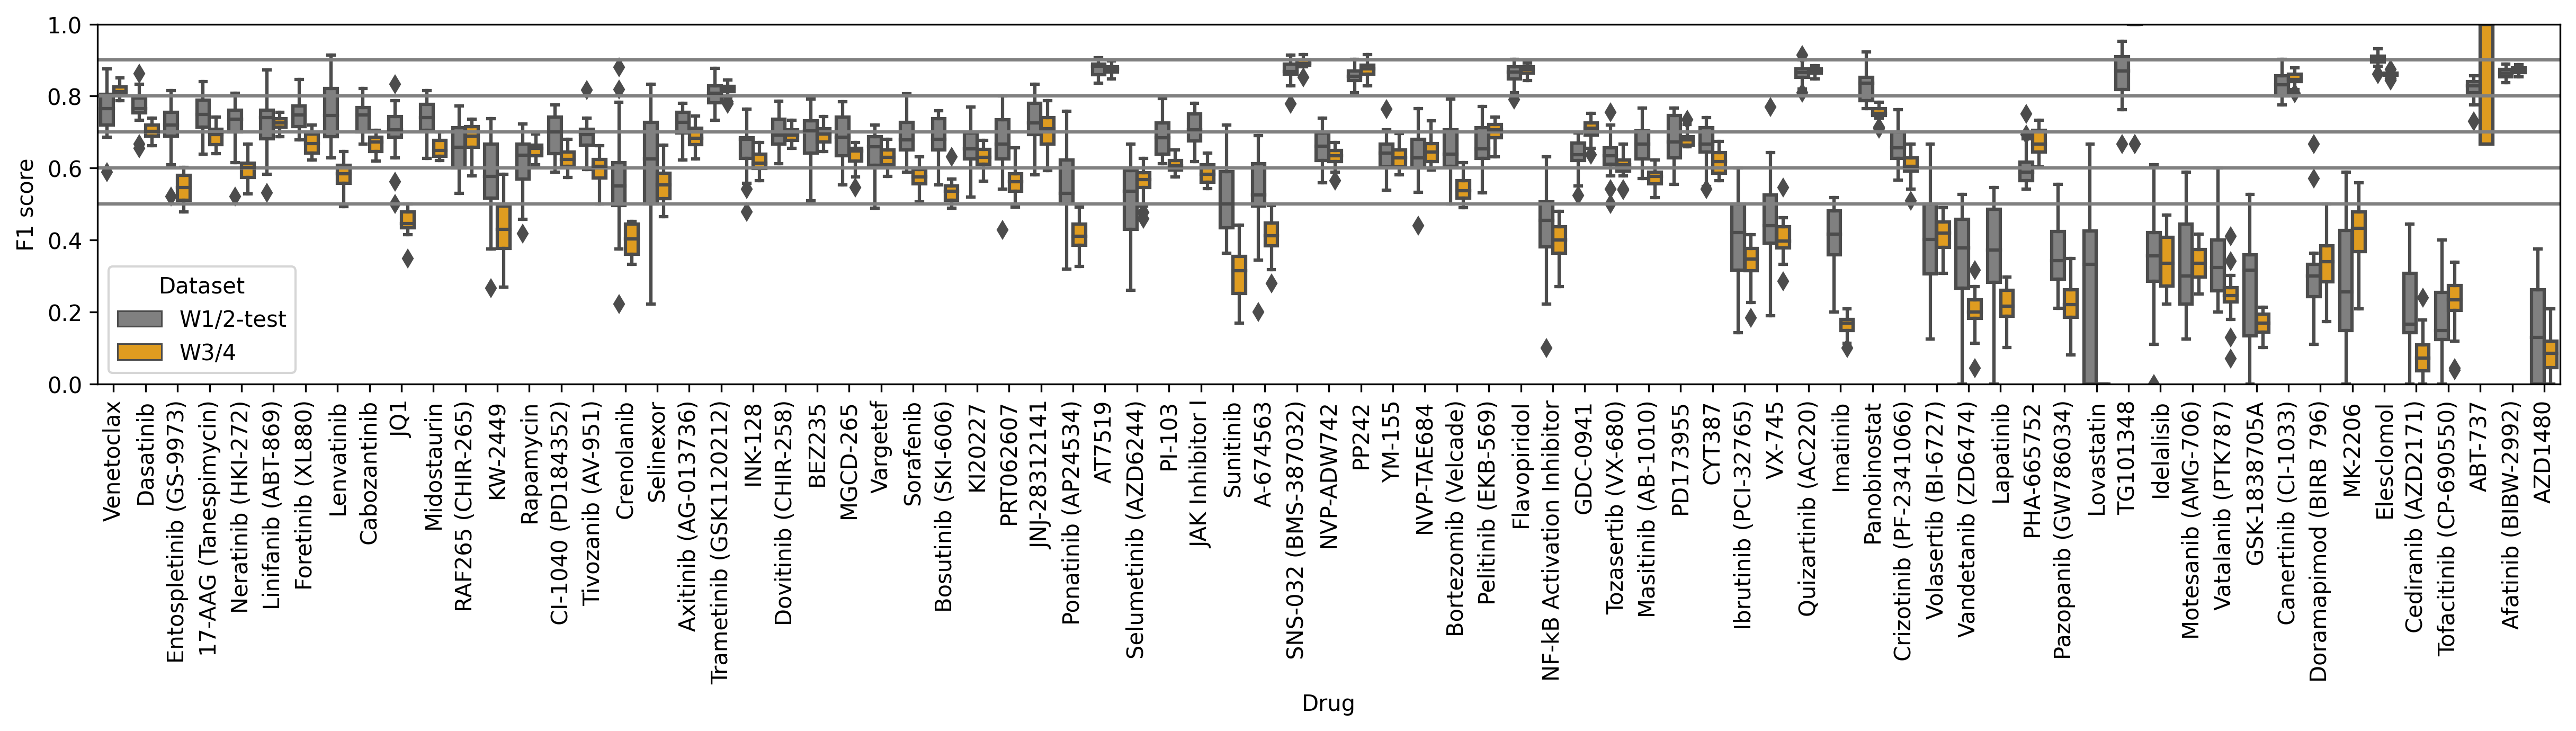

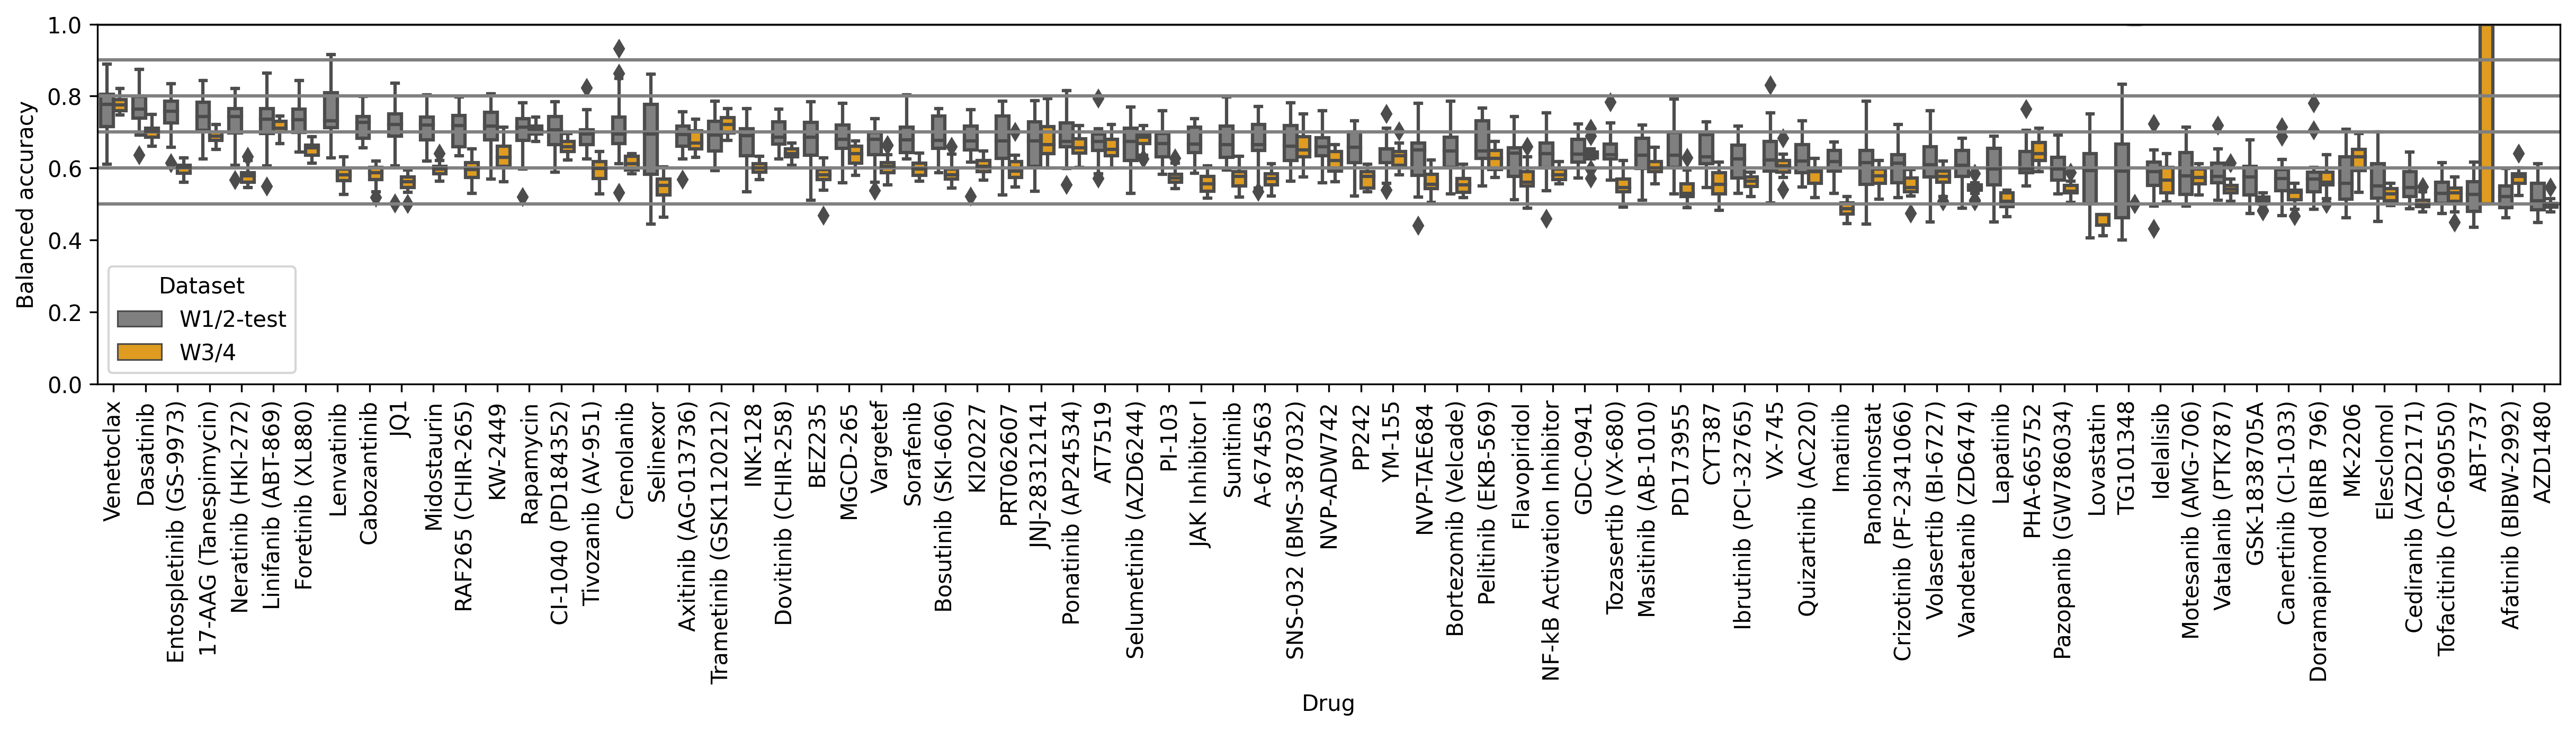

In [110]:
import seaborn as sns
plt.figure(figsize = (20,3),dpi = 300)
acc_df = pd.DataFrame({"Drug":list(selected_r['Drug'])+ list(selected_r['Drug']) + list(selected_r['Drug']),
                       "ACC":list(selected_r['ACC_train']) + list(selected_r['ACC1_2']) + list(selected_r['ACC_w3_4']),
                       "F1":list(selected_r['F1_train']) + list(selected_r['F1_w1_2']) + list(selected_r['F1_w3_4']),
                       "Dataset":['W1/2-train']*len(selected_r) + ['W1/2-test']*len(selected_r) + ['W3/4']*len(selected_r)})

acc_df = pd.DataFrame({"Drug": list(selected_r['Drug']) + list(selected_r['Drug']),
                       "ACC": list(selected_r['ACC1_2']) + list(selected_r['ACC_w3_4']),
                       "F1": list(selected_r['F1_w1_2']) + list(selected_r['F1_w3_4']),
                       "Dataset": ['W1/2-test']*len(selected_r) + ['W3/4']*len(selected_r)})


### F1                 
sns.boxplot(x="Drug", y="F1",
            hue="Dataset", palette=["grey",'orange', "red"],
            order = order_drugs['Drug'],
            data=acc_df)
#plt.ylim(0,1)
#plt.title(Drug.split("(")[0])
plt.xticks(range(0,len(order_drugs['Drug'])), order_drugs['Drug'], rotation = 90)
plt.ylim(0,1)
plt.ylabel("F1 score")
plt.axhline(y = 0.5, color = 'gray', linestyle = '-')
plt.axhline(y = 0.6, color = 'gray', linestyle = '-')
plt.axhline(y = 0.7, color = 'gray', linestyle = '-')
plt.axhline(y = 0.8, color = 'gray', linestyle = '-')
plt.axhline(y = 0.9, color = 'gray', linestyle = '-')

plt.show()

### ACC
plt.figure(figsize = (20,3),dpi = 300)

sns.boxplot(x="Drug", y="ACC",
            hue="Dataset", palette=["grey",'orange', "red"],
            order = order_drugs['Drug'],
            data=acc_df)
#plt.ylim(0,1)
#plt.title(Drug.split("(")[0])
plt.xticks(range(0,len(order_drugs['Drug'])), order_drugs['Drug'], rotation = 90)
plt.ylim(0,1)
#plt a line for y = 0.8
plt.axhline(y = 0.5, color = 'gray', linestyle = '-')
plt.axhline(y = 0.6, color = 'gray', linestyle = '-')
plt.axhline(y = 0.7, color = 'gray', linestyle = '-')
plt.axhline(y = 0.8, color = 'gray', linestyle = '-')
plt.axhline(y = 0.9, color = 'gray', linestyle = '-')
plt.axhline(y = 1, color = 'gray', linestyle = '-')

#plt.plot([-1, len(order_drugs['Drug'])], [0.8, 0.8], linewidth=1, color = "black")
#plt.plot([-1, len(order_drugs['Drug'])], [0.7, 0.7], linewidth=1, color = "black")

plt.ylabel("Balanced accuracy")
plt.show()

In [ ]:
# Get feature importance

In [111]:
feature_drug_df = pd.DataFrame()
for drug in order_drugs['Drug']:
    print(drug)
    test = result_with_threshod[drug]
    #print(test)
    #print(sele_threshold[drug])
    cur = test[sele_threshold[drug]]
    #print(cur)
    feature_df = pd.DataFrame()
    for random in cur:
        if cur[random]['balanced_acc'] > 0.7 :
            feature_df_cur = cur[random]['features']
            feature_df_cur["IMP_"+str(random)]  = feature_df_cur['IMP']
            feature_df_cur.index = feature_df_cur['Feature']
            feature_df = pd.concat([feature_df, feature_df_cur["IMP_"+str(random)] ], axis =1)
    feature_df_sum = feature_df.sum(axis = 1)/feature_df.shape[1]
    result = pd.DataFrame({"features":feature_df_sum.index, 
                           "IMP":feature_df_sum.values, 
                           "Drug":[drug]*len(feature_df_sum.index)})
    
    feature_drug_df = pd.concat([feature_drug_df, result])

Venetoclax
Dasatinib
Entospletinib (GS-9973)
17-AAG (Tanespimycin)
Neratinib (HKI-272)
Linifanib (ABT-869)
Foretinib (XL880)
Lenvatinib
Cabozantinib
JQ1
Midostaurin
RAF265 (CHIR-265)
KW-2449
Rapamycin
CI-1040 (PD184352)
Tivozanib (AV-951)
Crenolanib
Selinexor
Axitinib (AG-013736)
Trametinib (GSK1120212)
INK-128
Dovitinib (CHIR-258)
BEZ235
MGCD-265
Vargetef
Sorafenib
Bosutinib (SKI-606)
KI20227
PRT062607
JNJ-28312141
Ponatinib (AP24534)
AT7519
Selumetinib (AZD6244)
PI-103
JAK Inhibitor I
Sunitinib
A-674563
SNS-032 (BMS-387032)
NVP-ADW742
PP242
YM-155
NVP-TAE684
Bortezomib (Velcade)
Pelitinib (EKB-569)
Flavopiridol
NF-kB Activation Inhibitor
GDC-0941
Tozasertib (VX-680)
Masitinib (AB-1010)
PD173955
CYT387
Ibrutinib (PCI-32765)
VX-745
Quizartinib (AC220)
Imatinib
Panobinostat
Crizotinib (PF-2341066)
Volasertib (BI-6727)
Vandetanib (ZD6474)
Lapatinib
PHA-665752
Pazopanib (GW786034)
Lovastatin
TG101348
Idelalisib
Motesanib (AMG-706)
Vatalanib (PTK787)
GSK-1838705A
Canertinib (CI-1033)
Doram

In [280]:
#feature_drug_df.loc[feature_drug_df['Drug'] == "JQ1"].sort_values(by = ['IMP'], ascending = False).head(10)

In [112]:
feature_drug_df.to_csv("IMP_Feature_matrix_acc_gt0.7_Jun20.csv")

In [124]:
feature_drug_df_sig = feature_drug_df.loc[feature_drug_df['IMP'] > 0.005]
#feature_drug_df_sig
feature_drug_df_sig.to_csv("IMP_Feature_matrix_acc_gt0.7_IMP_gt0.005_Jun20.csv")

In [268]:
#feature_drug_df_sig.to_csv("IMP_Feature_matrix_acc_gt0.8_IMP_gt0.005_Mar3.csv")
#feature_drug_df_sig.to_csv("IMP_Feature_matrix_acc_gt0.8_IMP_gt0.005_Jun20.csv")

In [ ]:
#End here!!!!

In [125]:
feature_drug_df_sig.loc[feature_drug_df_sig['features'] == "WT1"]

features       IMP                  Drug
79       WT1  0.006602             Selinexor
45       WT1  0.005238              MGCD-265
22       WT1  0.012023              A-674563
70       WT1  0.005254  SNS-032 (BMS-387032)
68       WT1  0.006453              GDC-0941
110      WT1  0.007598   Tozasertib (VX-680)
84       WT1  0.006312              PD173955
27       WT1  0.014114            Idelalisib
34       WT1  0.012846   Motesanib (AMG-706)
8        WT1  0.023808    Vatalanib (PTK787)

In [126]:
feature_drug_df_sig.sort_values(by = ['Drug'])
feature_drug_df_sig.loc[feature_drug_df_sig['Drug'] == "Venetoclax"]

features       IMP        Drug
0               NPC2-GATA2  0.101879  Venetoclax
1             FGD4-MIR4519  0.066443  Venetoclax
2               FGD4-RPS10  0.017688  Venetoclax
3                BCL2-RELB  0.015544  Venetoclax
4             IGF2R-COX6A1  0.022394  Venetoclax
5               NPC2-SF3B2  0.013158  Venetoclax
6               BCL2-BECN1  0.020570  Venetoclax
7            CASC10-POU6F1  0.029907  Venetoclax
8      ZSCAN16-AS1-MIR4312  0.005732  Venetoclax
9            VENTX-MIR4519  0.007756  Venetoclax
10          LILRA3-MIR3153  0.007505  Venetoclax
11           ECHDC3-MIR940  0.019555  Venetoclax
12        SMC5-AS1-MIR378I  0.006776  Venetoclax
13    RP11-108L7.4-MIR3128  0.013337  Venetoclax
14             MTSS1-CEBPA  0.010346  Venetoclax
15             PLA2G6-FNTA  0.006909  Venetoclax
16            IGF2R-DNAJC1  0.027120  Venetoclax
17              BCL2-FOXO1  0.013008  Venetoclax
19            VENTX-COX6A1  0.007438  Venetoclax
20              NPC2-PSMB2  0.014355  Venetoclax
21             CASC10-FNTA  0.008061  Venetoclax
22            ECHDC3-RPS10  0.009405  Venetoclax
23             HDAC5-BECN1  0.006180  Venetoclax
24               NPC2-CTCF  0.016192  Venetoclax
25     RP11-83N9.5-MIR644A  0.009881  Venetoclax
27       LINC00471-MIR378I  0.008984  Venetoclax
29          EEF1GP2-MIR635  0.009281  Venetoclax
30             DPF2-COX6A1  0.009784  Venetoclax
31             GDF11-ZFP92  0.009055  Venetoclax
32           CNOT7P1-RPS10  0.008179  Venetoclax
33            C1QA-MIR4519  0.019615  Venetoclax
34          ZNF502-MIR4453  0.009386  Venetoclax
36                PAM-FNTA  0.009190  Venetoclax
37           CLASP1-POU2F2  0.006662  Venetoclax
38              MTSS1-FNTA  0.014634  Venetoclax
40            LILRA3-BECN1  0.005478  Venetoclax
41              GDF11-RBPJ  0.007594  Venetoclax
42             CLIP4-RPS10  0.008764  Venetoclax
45               CD14-FNTA  0.006856  Venetoclax
47                    IDH2  0.011939  Venetoclax
51              PAM-ZNF680  0.007612  Venetoclax
57     RP11-355B11.2-RPS10  0.005274  Venetoclax
64              UBE2M-ETS1  0.006671  Venetoclax
76              GDF11-FNTA  0.005613  Venetoclax
85               FGD4-FNTA  0.006623  Venetoclax
90            GDF11-COX6A1  0.007471  Venetoclax
91                    NPM1  0.010445  Venetoclax
94                  DNMT3A  0.005180  Venetoclax
95            LILRB2-BECN1  0.012176  Venetoclax
106           GOLGA8J-LEF1  0.005447  Venetoclax
113            LILRA3-FNTA  0.007830  Venetoclax
117             BCL2-NFKB2  0.023651  Venetoclax
125             NPC2-ATF6B  0.011083  Venetoclax
136           CASC10-RPS10  0.006739  Venetoclax
138             IGF2R-CUX1  0.006773  Venetoclax
150          LILRB2-COX6A1  0.006422  Venetoclax
158  RP11-355B11.2-MIR4519  0.005091  Venetoclax

In [127]:
feature_drug_df_sig
drug_family = ["Bosutinib (SKI-606)", "Dasatinib","Imatinib","Nilotinib","PD173955","Ponatinib (AP24534)"]
features_sele = feature_drug_df_sig.loc[feature_drug_df_sig['Drug'].isin(drug_family)]
feature_list_sele = []
for feature in set(features_sele['features']):
    if features_sele.loc[features_sele['features'] == feature].shape[0]>=2:
        feature_list_sele.append(feature)

feature_common = features_sele.loc[features_sele['features'].isin(feature_list_sele)]
feature_common['Drug_Family'] = ['ABL']*feature_common.shape[0]

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_94719/781259054.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_common['Drug_Family'] = ['ABL']*feature_common.shape[0]


In [128]:
feature_common.to_csv("ABL_family_common_features.csv")

In [129]:
#CDK4_6 or pan-CDK predictors
feature_drug_df_sig
drug_family = ["AT7519", "Flavopiridol", "Palbociclib", "BMS-35541", "JNJ-776621", "Roscovitine (CYC-202)",  "SNS-032 (BMS-387032)"]
features_sele = feature_drug_df_sig.loc[feature_drug_df_sig['Drug'].isin(drug_family)]
feature_list_sele = []
for feature in set(features_sele['features']):
    if features_sele.loc[features_sele['features'] == feature].shape[0]>=2:
        feature_list_sele.append(feature)

feature_common = features_sele.loc[features_sele['features'].isin(feature_list_sele)]
feature_common['Drug_Family'] = ['pan-CDK']*feature_common.shape[0]

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_94719/1873044831.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_common['Drug_Family'] = ['pan-CDK']*feature_common.shape[0]


In [130]:
feature_common.to_csv("pan_CDK_family_common_features.csv")

In [131]:
#RAF_MEK_ERK inhibitor
feature_drug_df_sig
drug_family = ["CL-1040 (PD184352)", "GDC-0879", "PD173955", "RAF265 (CHIR-265)", "Regorafenib (BAY 73-4506)", "Selumetinib (AZD6244)", "Trametinib (GSK1120212)", "Vemurafenib (PLX-4032)"]
features_sele = feature_drug_df_sig.loc[feature_drug_df_sig['Drug'].isin(drug_family)]
feature_list_sele = []
for feature in set(features_sele['features']):
    if features_sele.loc[features_sele['features'] == feature].shape[0]>=2:
        feature_list_sele.append(feature)

feature_common = features_sele.loc[features_sele['features'].isin(feature_list_sele)]
feature_common['Drug_Family'] = ['RAF_MEK_ERK']*feature_common.shape[0]

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_94719/187090638.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_common['Drug_Family'] = ['RAF_MEK_ERK']*feature_common.shape[0]


In [132]:
#feature_common
feature_common.to_csv("RAF_MEK_ERK_family_common_features.csv")

In [134]:
#RAF_MEK_ERK inhibitor
feature_drug_df_sig
drug_family = ["Venetoclax","ABT737","ABT263","ABT199"]
features_sele = feature_drug_df_sig.loc[feature_drug_df_sig['Drug'].isin(drug_family)]
feature_list_sele = []
for feature in set(features_sele['features']):
    if features_sele.loc[features_sele['features'] == feature].shape[0]>=2:
        feature_list_sele.append(feature)

feature_common = features_sele.loc[features_sele['features'].isin(feature_list_sele)]
feature_common['Drug_Family'] = ['BCL2 family inhibitor']*feature_common.shape[0]

feature_common.to_csv("BCL2_family_common_features.csv")

In [122]:
feature_drug_df_sig.loc[feature_drug_df_sig['features'] == 'ABCB1-ZNF91']

Empty DataFrame
Columns: [features, IMP, Drug]
Index: []

In [135]:
feature_drug_df.loc[feature_drug_df['Drug'].isin(drug_family)]

features       IMP        Drug
0      NPC2-GATA2  0.101879  Venetoclax
1    FGD4-MIR4519  0.066443  Venetoclax
2      FGD4-RPS10  0.017688  Venetoclax
3       BCL2-RELB  0.015544  Venetoclax
4    IGF2R-COX6A1  0.022394  Venetoclax
..            ...       ...         ...
199   PLA2G6-KLF4  0.000002  Venetoclax
200    SUN1-KDM5B  0.000708  Venetoclax
201   MYO7A-PRDM8  0.000975  Venetoclax
202         ASXL1  0.000852  Venetoclax
203    IGF2R-AUP1  0.000523  Venetoclax

[204 rows x 3 columns]

In [138]:
common_feature_gt2 = set()
for feature in set(feature_drug_df_sig['features']):
    if feature_drug_df_sig.loc[feature_drug_df_sig['features'] == feature].shape[0]>2:
        common_feature_gt2.add(feature)
print(len(common_feature_gt2))

feature_drug_df_sig.loc[feature_drug_df_sig['features'].isin(common_feature_gt2)].to_csv("common_features_gt2.csv")

235


In [532]:
# Visulize the effect of predictors and drug response

# Not used!

0.36


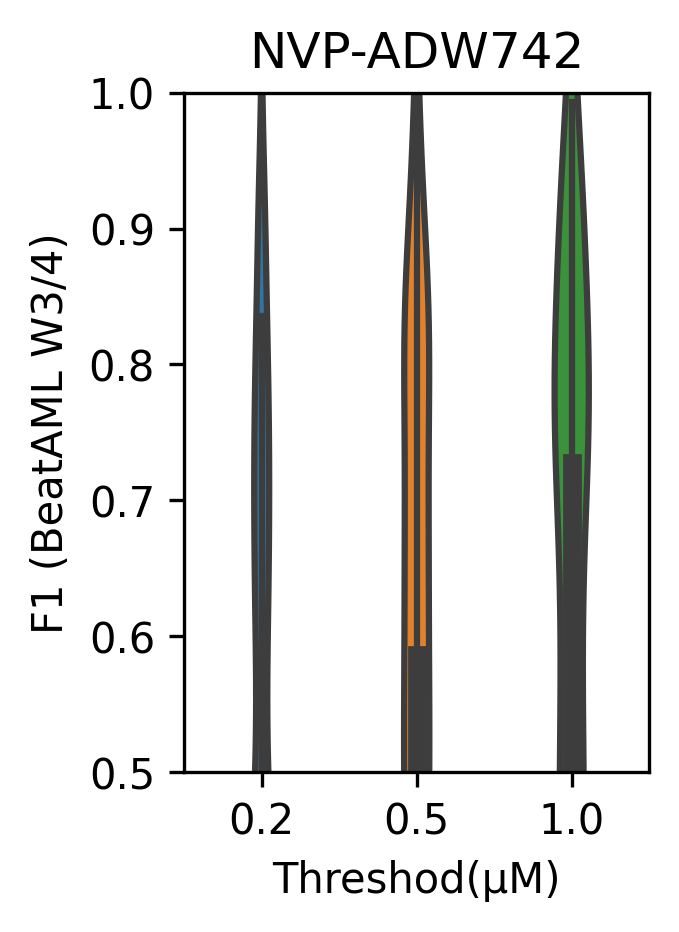

In [90]:
import seaborn as sns
plt.figure(figsize = (2,3),dpi = 300)
r = pd.DataFrame({"Threshod(μM)":Threshold_list, "F1_w3":F1_independent_test_list})
sns.violinplot(data=pd.DataFrame({"Threshod(μM)":Threshold_list, "F1_w3":F1_independent_test_list}),
               x="Threshod(μM)", y="F1_w3"
              )
plt.ylim(0.5,1)
plt.ylabel("F1 (BeatAML W3/4)")
plt.title(Drug.split("(")[0])
print(np.median(r.loc[r['Threshod(μM)'] == 1]['F1_w3']))

In [117]:
# Plot top important features 
feature_IMP =pd.DataFrame()
Threshold = 1
for random_state in result_with_threshod[Threshold]:
    features = result_with_threshod[Threshold][random_state]['features']['Feature'].values
    IMP = result_with_threshod[Threshold][random_state]['features']['IMP'].values
    cur_df = pd.DataFrame({"IMP" + str(random_state): IMP})
    cur_df.index = features
    feature_IMP = pd.concat([feature_IMP,cur_df ],axis =1)
    
IMP_sum = feature_IMP.transpose().sum()
x_feature = pd.DataFrame({"Feature":IMP_sum.index, "IMP":IMP_sum.values})
x_feature_sorted = x_feature.sort_values(by = ["IMP"], ascending = False).head(100)



In [118]:
 x_feature.sort_values(by = ["IMP"], ascending = False).to_csv("Trametinib_features.csv")

([<matplotlib.axis.XTick at 0x13dffd0f0>,
 [Text(0, 0, 'ATXN7L3-CTCF'),
  Text(1, 0, 'CTD-2006K23.1-MIR3679'),
  Text(2, 0, 'MT-TS1-PSMC1'),
  Text(3, 0, 'OSBPL1A-GPS2'),
  Text(4, 0, 'TNS1-ZBTB18'),
  Text(5, 0, 'NPM1P12-MIR1282'),
  Text(6, 0, 'RP11-267J23.4-MIR4426'),
  Text(7, 0, 'REPS2-GPS2'),
  Text(8, 0, 'OSBPL1A-RORA'),
  Text(9, 0, 'MED13L-SF3B2'),
  Text(10, 0, 'MT-TS1-ZNF91'),
  Text(11, 0, 'RP13-228J13.8-MIR146A'),
  Text(12, 0, 'MLLT10-GABPA'),
  Text(13, 0, 'MT-TS1-GPS2'),
  Text(14, 0, 'OSBPL1A-ZNF91'),
  Text(15, 0, 'TNS1-ZFHX3'),
  Text(16, 0, 'NPAS1-MYCL'),
  Text(17, 0, 'YME1L1-ARAF'),
  Text(18, 0, 'RALGAPA1-ZNF721'),
  Text(19, 0, 'HMGN2P41-RPS10'),
  Text(20, 0, 'RP11-267J23.4-GPS1'),
  Text(21, 0, 'NPM1'),
  Text(22, 0, 'RP11-255C15.4-MIR4639'),
  Text(23, 0, 'YME1L1-PSMD2'),
  Text(24, 0, 'RP11-267J23.4-MLH1'),
  Text(25, 0, 'REPS2-ZNF91'),
  Text(26, 0, 'MT-TS1-FNTA'),
  Text(27, 0, 'CTD-2061E19.1-MIR371B'),
  Text(28, 0, 'RPL39P38-MIR421'),
  Text(29, 0, 'IMPA

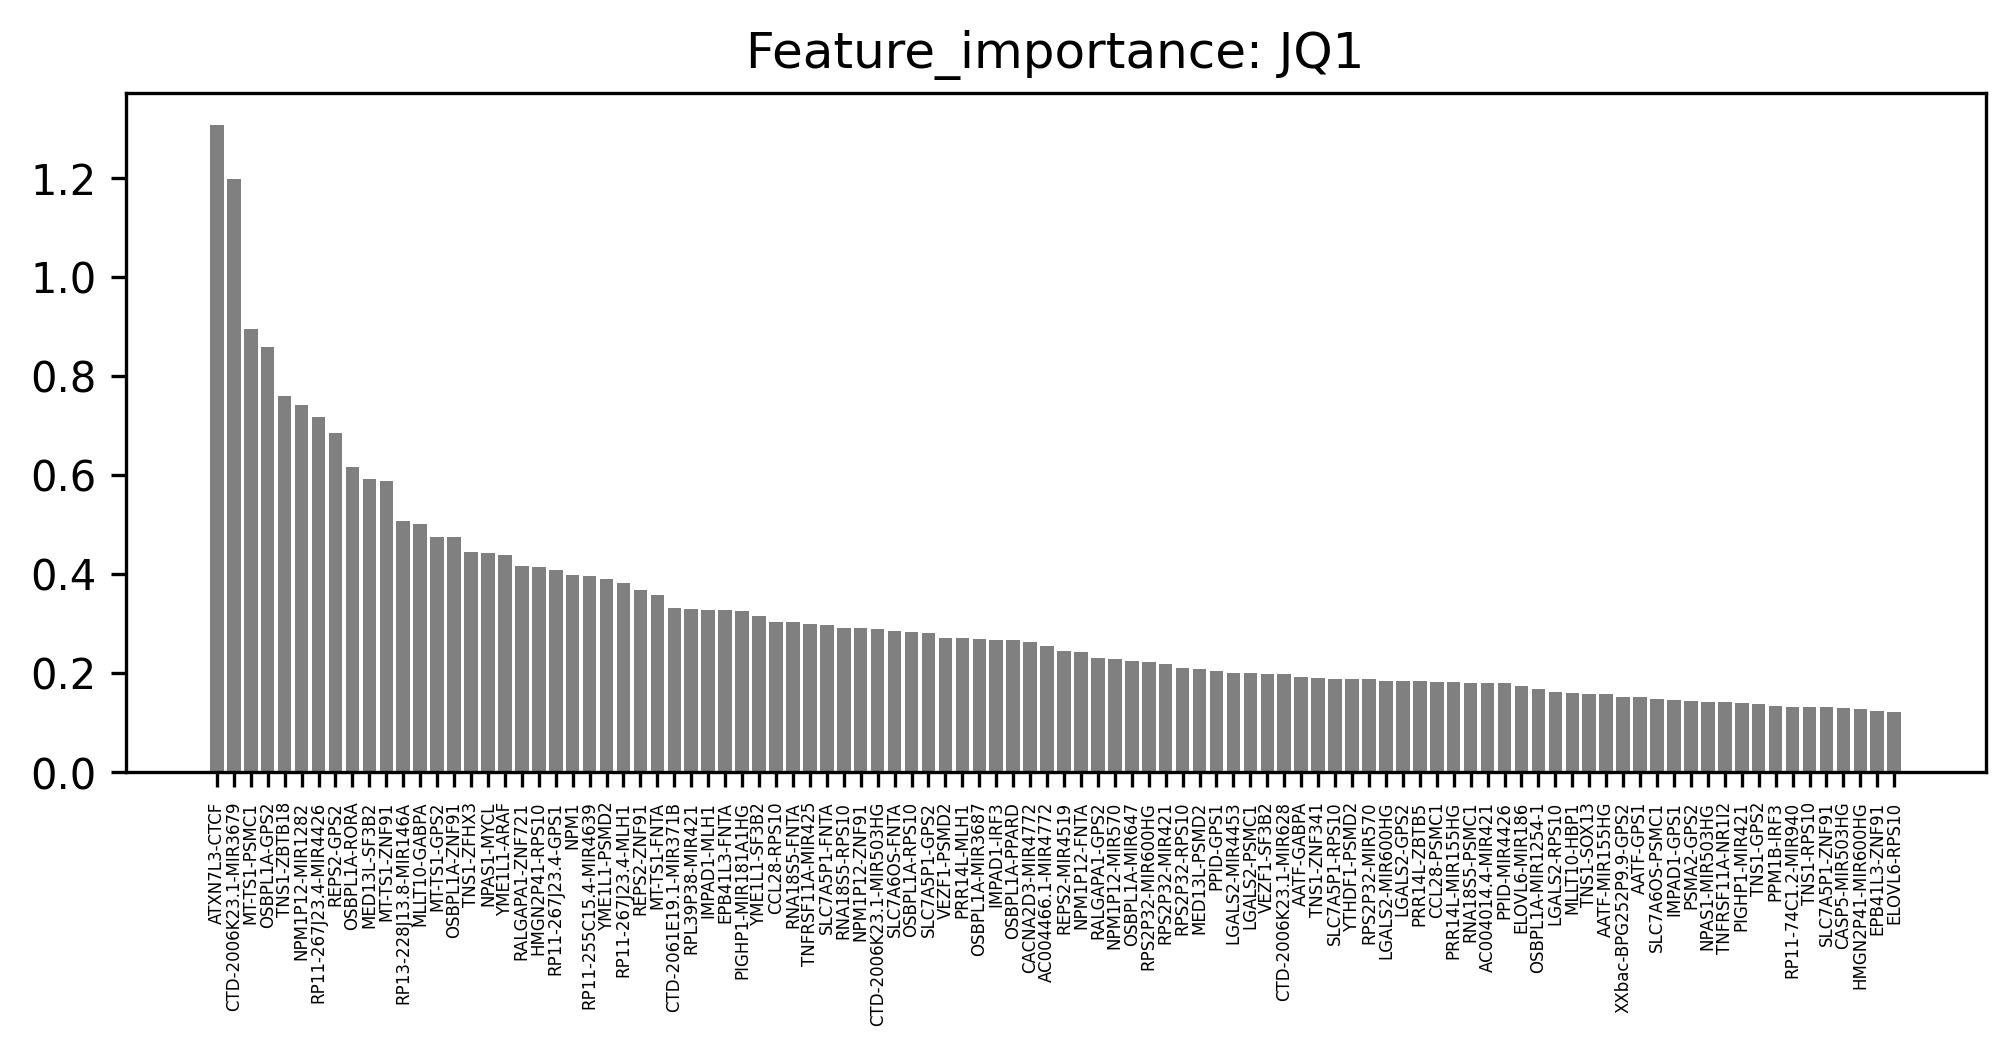

In [119]:
plt.figure(figsize = (8,3),dpi = 300)
plt.title("Feature_importance: " + Drug.split("(")[0])
plt.bar(np.arange(0,x_feature_sorted.shape[0], 1), x_feature_sorted['IMP'], width=0.8,  color = 'grey',
        bottom=None,  align='center')
#plt.ylabel("correlation coeffient")
plt.xticks(np.arange(0,x_feature_sorted.shape[0], 1),x_feature_sorted['Feature'] , rotation = 90, fontsize =4)


0.8055555555555556


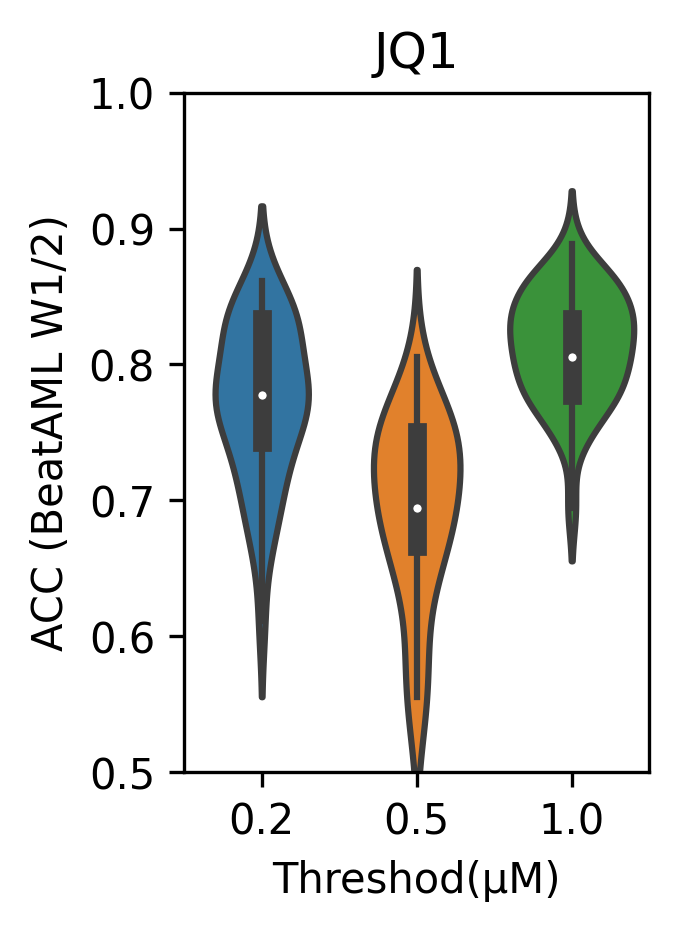

In [120]:
import seaborn as sns
plt.figure(figsize = (2,3),dpi = 300)
acc_df=pd.DataFrame({"Threshod(μM)":Threshold_list, "ACC":ACC_list})
sns.violinplot(data=pd.DataFrame({"Threshod(μM)":Threshold_list, "ACC":ACC_list}), x="Threshod(μM)", y="ACC")
plt.ylim(0.5,1)
plt.ylabel("ACC (BeatAML W1/2)")
plt.title(Drug.split("(")[0])
print(np.median(acc_df.loc[acc_df['Threshod(μM)'] == 1]['ACC']))

0.8870673952641166


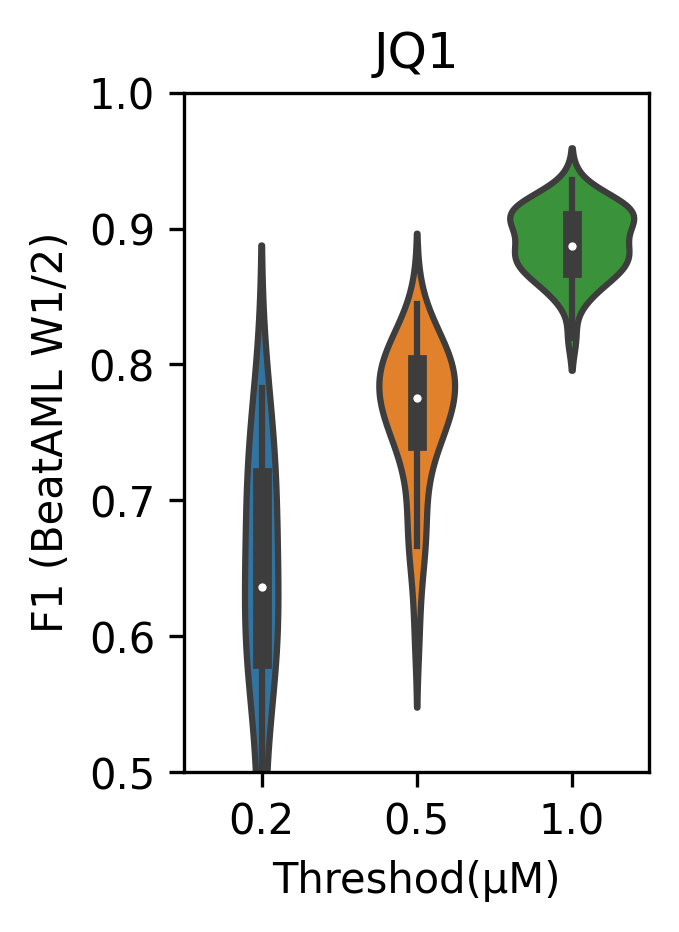

In [121]:
import seaborn as sns
plt.figure(figsize = (2,3),dpi = 300)
f1_df = pd.DataFrame({"Threshod(μM)":Threshold_list, "F1_score":F1_list})
sns.violinplot(data=f1_df, x="Threshod(μM)", y="F1_score")
#plt.title("Validation Set")
plt.ylim(0.5,1)
plt.ylabel("F1 (BeatAML W1/2)")
plt.title(Drug.split("(")[0])

print(np.median(f1_df.loc[acc_df['Threshod(μM)'] == 1]['F1_score']))

In [122]:
print(np.median(f1_df.loc[f1_df['Threshod(μM)'] == 1]['F1_score']))
print(np.median(acc_df.loc[acc_df['Threshod(μM)'] == 1]['ACC']))


0.8870673952641166
0.8055555555555556
